In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating new environment at `~/SSD/Code/Julia/tinympc-dev-julia/rocket_landing_Zac/Project.toml`


In [2]:
using LinearAlgebra
using PyPlot
using Printf

In [3]:
include("../LibTinyMPC.jl")

export_mat_to_c (generic function with 1 method)

In [70]:
#Rocket landing
NSTATES = 6
NINPUTS = 3
NHORIZON = 301
NTOTAL = 301

# Initialize cache, settings, bounds, socs, workspace, solver

###### Cache
rho = 1e0
Kinf = zeros(NINPUTS,NSTATES)
Pinf = zeros(NSTATES,NSTATES)
Quu_inv = zeros(NINPUTS,NINPUTS)
AmBKt = zeros(NSTATES,NSTATES)
APf = zeros(NSTATES)
BPf = zeros(NINPUTS)
my_cache = TinyCache(rho, Kinf, Pinf, Quu_inv, AmBKt, APf, BPf)
#####

##### Settings
abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 2000
check_termination = 1
en_state_bound = 0  # ENABLE CONSTRAINTS OR NOT
en_input_bound = 1
en_state_soc = 0
en_input_soc = 1
my_stgs = TinySettings(abs_pri_tol, abs_dua_tol, max_iter, check_termination, en_state_bound, en_input_bound, en_state_soc, en_input_soc)
#####

###### Bounds
umin = -10.0*ones(NINPUTS, NHORIZON-1)
umax = 105*ones(NINPUTS, NHORIZON-1)
xmin = repeat([-5; -5; -0.5; -10; -10; -20], 1, NHORIZON)
xmax = repeat([5; 5; 100.0; 10; 10; 20], 1, NHORIZON)
z = zeros(NINPUTS, NHORIZON-1)
znew = zeros(NINPUTS, NHORIZON-1)
v = zeros(NSTATES, NHORIZON)
vnew = zeros(NSTATES, NHORIZON)
y = zeros(NINPUTS, NHORIZON-1)
g = zeros(NSTATES, NHORIZON)
my_bounds = TinyBounds(umin, umax, xmin, xmax, z, znew, v, vnew, y, g)
#####

##### SOCS
ncu = 1
ncx = 1
cu = [0.4, 0]  # 0.3 is the thrust coefficient
cx = [0.6, 0]
qcu = [3, 0]  # 3 is the dimensions of 1st cone
qux = [3, 0]
Acu = [1, 0]
Acx = [1, 0]
zc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
zcnew = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vcnew = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
yc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
gc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
my_socs = TinySocs(ncu, ncx, cu, cx, qcu, qux, Acu, Acx, zc, zcnew, vc, vcnew, yc, gc)
#####

##### Workspace
x = zeros(NSTATES, NHORIZON)
u = zeros(NINPUTS, NHORIZON-1)
q = zeros(NSTATES, NHORIZON)
r = zeros(NINPUTS, NHORIZON-1)
p = zeros(NSTATES, NHORIZON)
d = zeros(NINPUTS, NHORIZON-1)
pri_res_state = 1.0
pri_res_input = 1.0
dua_res_state = 1.0
dua_res_input = 1.0
status = 0
iter = 0
Q = 1e2*I(NSTATES)
R = 1e0*I(NINPUTS)
Adyn = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
Bdyn = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
fdyn = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905] * 1

h = 0.05
t = h*(0:NTOTAL-1)
Xref = zeros(NSTATES, NTOTAL)
x0 = [4, 2, 20, -3, 3, -5.0]  # INITIAL STATE
# x0 = [4, 2, 20, -2, 1, -4.0]
x[:,1] = 1*x0
xg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for k = 1:NTOTAL
  Xref[:,k] = x0 + (xg - x0)*(k-1)/(NTOTAL-1)
  # Xref[4:6,k] = [0, 0, 0]
  # Xref[:,k] = xg*1
end
Uref = repeat([0; 0; 10.0], 1, NTOTAL-1) 
Xref_hrz = 1*Xref[:,1:NHORIZON]
Uref_hrz = 1*Uref[:,1:NHORIZON-1]
# Could provide a better reference from other solvers

Qu = zeros(NINPUTS, NINPUTS)
my_work = TinyWorkspace(x, u, q, r, p, d, pri_res_state, pri_res_input, dua_res_state, dua_res_input, status, iter, Q, R, Adyn, Bdyn, fdyn, Xref_hrz, Uref_hrz, Qu, my_bounds, my_socs)
#####

# Solver
solver = TinySolver(my_stgs, my_cache, my_work)

TinySolver(TinySettings(0.01, 0.01, 2000, 1, 0, 1, 0, 1), TinyCache(1.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), TinyWorkspace([4.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0; … ; 3.0 0.0 … 0.0 0.0; -5.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 1.0, 1.0, 1.0, 1.0, 0, 0, [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 … 0.0 0.0

In [71]:
compute_cache!(solver)
solve_admm!(solver)

(40.90136436416812, 0, 2000)

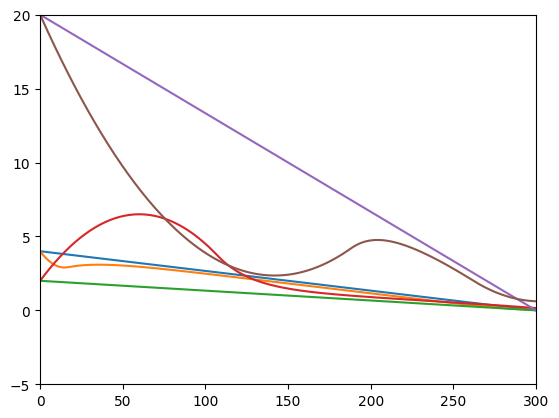

In [72]:
fig = plt.figure()
plot(Xref[1,:]) # z
plot(x[1,:])
plot(Xref[2,:]) # z
plot(x[2,:])
plot(Xref[3,:]) # z
plot(x[3,:])
# put limit on axis
plt.ylim(-5, 20)
plt.xlim(0, 300)
fig

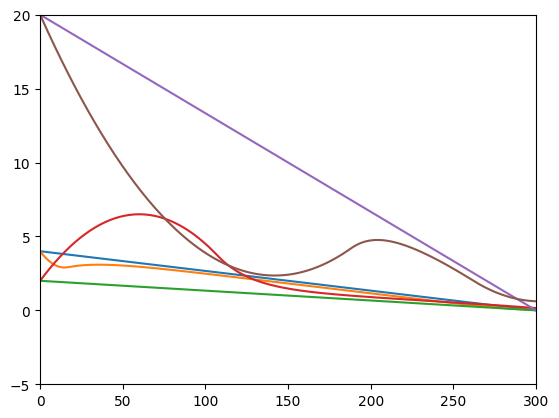

In [73]:
fig = plt.figure()
plot(Xref[1,:]) # z
plot(x[1,:])
plot(Xref[2,:]) # z
plot(x[2,:])
plot(Xref[3,:]) # z
plot(x[3,:])
# put limit on axis
plt.ylim(-5, 20)
plt.xlim(0, 300)
fig

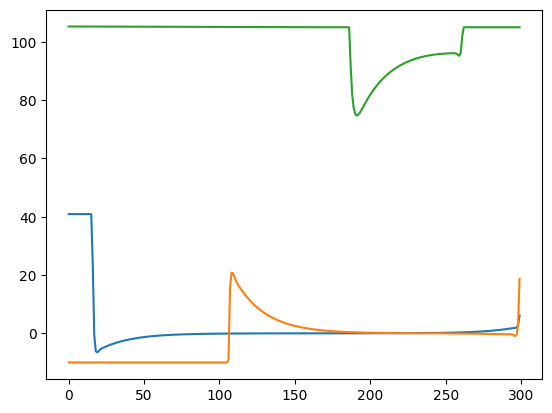

In [74]:
fig = plt.figure()
plot(solver.workspace.u[1,:])
plot(u[2,:])
plot(u[3,:])
fig

In [75]:
vio_count = 0
for idx in 1:NHORIZON-1
    # (sqrt(u[1,idx]^2 + u[2,idx]^2) - cu[1]*u[3,idx] >= 1e-2) && (vio_count += 1)  # test cone constraint
    (sqrt(x[1,idx]^2 + x[2,idx]^2) - cx[1]*x[3,idx] >= 1e-2) && (vio_count += 1)  # test cone constraint
end
print("vio_count = ", vio_count, "\n")
print("max control = ", maximum(u[:, :]), "\n")
print("min control = ", minimum(u[:, :]), "\n")
print("max state = ", maximum(x[2,:]))

vio_count = 132
max control = 105.26486098293175
min control = -9.999993400495331
max state = 6.500021328086551

In [76]:
idx = 1
sqrt(u[1,idx]^2 + u[2,idx]^2) - cu[1]*u[3,idx]

0.00011368180146575924

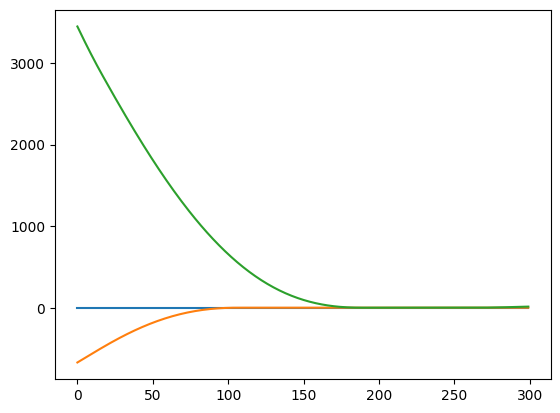

In [77]:
fig = plt.figure()
plot(y[1,:])
plot(y[2,:])
plot(y[3,:])
fig